In [1]:
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List
import matplotlib.pyplot as plt

# 02. Fundamentals
In `Chapter 1`, I described the major conceptual building block for understanding deep learning: nested, continuous, differentiable functions. I showed how to represent these functions as computational graphs, with each node in a graph representing a single, simple function. In particular, I demonstrated that such a representation showed easily how to calculate the derivative of the output of the nested function with respect to its input: we simply take the derivatives of all the constituent functions, evaluate these derivatives at the input that these functions received, and then multiply all of the results together; this will result in a correct derivative for the nested function because of the chain rule. I illustrated that this does in fact work with some simple examples, with functions that took NumPy’s ndarrays as inputs and produced ndarrays as outputs.

In this chapter, we’ll start translating these concepts into real-world applications, Specifically, we will:
1. Express linear regression in terms of these building blocks
2. Show that the reasoning around derivatives that we did in Chapter 1 allows us to train this linear regression model
3. Extend this model (still using our building blocks) to a one-layer neural network

## 2.1 Supervised Learning Overview
At a high level, machine learning can be described as building algorithms that can uncover or “learn” relationships in data; supervised learning can be described as the subset of machine learning dedicated to finding relationships between characteristics of the data that have already been measured.

## 2.2 Supervised Learning Models
The goal is to find (a mathematical function) / (a function that takes an ndarray as input and produces an ndarray as output) that can (map characteristics of observations to the target) / (given an input ndarray containing the features we created, produce an output ndarray whose values are “close to” the ndarray containing the target).

## 2.3 Linear Regression
Linear regression is often shown as:

$$y_i = \beta_0+\beta_1*x_1+\beta_2*x_2+\cdots+\beta_n*x_k+\varepsilon$$

As we saw in `Chapter 1`, if we can represent these operations as just a matrix multiplication, we’ll be able to write the function more concisely while still being able to correctly calculate the derivative of the output with respect to the input, which will allow us to train the model.

First, let’s handle the simpler scenario in which we don’t have an intercept term ($\beta_0$ shown previously). Note that we can represent the output of a linear regression model as the dot product of each observation vector $x_i = [x_1 x_2 x_3 \cdots x_k]$ with another vector of parameters that we’ll call $W$:

$$W = \begin{bmatrix} w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_k \end{bmatrix}$$

Our prediction would then simply be:

$$p_i = x_i \times W = w_1 \times x_{i1} + w_2 \times x_{i2} + \cdots + w_k \times x_{ik}$$

Furthermore, when we want to make predictions using linear regression with a batch of observations, we can use another, single operation: the matrix multiplication. If we have a batch of size 3, for example:

$$X_{batch} = \begin{bmatrix} x_{11} & x_{12} & x_{13} & \cdots & x_{1k} \\ x_{21} & x_{22} & x_{23} & \cdots & x_{2k} \\ x_{31} & x_{32} & x_{33} & \cdots & x_{3k} \end{bmatrix}$$

then performing the matrix multiplication of this batch $X_{batch}$ with $W$ gives a vector of predictions for the batch, as desired:

$$P_{batch} = X_{batch}\times W = \begin{bmatrix} x_{11} & x_{12} & x_{13} & \cdots & x_{1k} \\ x_{21} & x_{22} & x_{23} & \cdots & x_{2k} \\ x_{31} & x_{32} & x_{33} & \cdots & x_{3k} \end{bmatrix} \times \begin{bmatrix} w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_k \end{bmatrix} = \begin{bmatrix} p_1 \\ p_2 \\ p_3 \end{bmatrix}$$

To train our model, however, we need another crucial piece of information: whether or not these predictions are good. We use RMSE or MAE loss functions:

In [2]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

Getting to the result of loss function, which we can call $L$, is key: once we have it, we can use all the techniques we saw in `Chapter 1` to compute the gradient of this number with respect to each element of $W$. Then we can use these derivatives to update each element of $W$ in the direction that would cause $L$ to decrease. Repeating this procedure many times, we hope, will “train” our model; in this chapter, we’ll see that this can indeed work in practice. To see clearly how to compute these gradients, we’ll complete the process of representing linear regression as a computational graph.

### Linear Regression: The Code
We’ll now tie things together and code up the function that makes predictions and computes losses given batches of observations $X_{batch}$ and their corresponding targets $y_{batch}$. Recall that computing derivatives for nested functions using the chain rule involves two sets of steps: first, we perform a “forward pass,” passing the input successively forward through a series of operations and saving the quantities computed as we go; then we use those quantities to compute the appropriate derivatives during the backward pass.

<img src="images/02_04.png" style="width:600px;"/>

The following code does this, saving the quantities computed on the forward pass in a dictionary; furthermore, to differentiate between the quantities computed on the forward pass and the parameters themselves (which we’ll also need for the backward pass), our function will expect to receive a dictionary containing the parameters:

In [3]:
def forward_linear_regression(X_batch: ndarray, y_batch: ndarray, 
                              weights: Dict[str, ndarray])-> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    # assert batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]
    # assert that matrix multiplication can work
    assert X_batch.shape[1] == weights['W'].shape[0]
    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1
    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])
    P = N + weights['B']
    loss = np.mean(np.power(y_batch - P, 2))
    # save the information computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    return loss, forward_info

## 2.4 Training the Model
We are now going to use all the tools we learned in the last chapter to compute $\displaystyle\frac{\partial L}{\partial w_i}$ for every $w_i$ in $W$, as well as $\displaystyle\frac{\partial L}{\partial b}$. How? Well, since the “forward pass” of this function was passing the input through a series of nested functions, the backward pass will simply involve computing the partial derivatives of each function, evaluating those derivatives at the functions’ inputs, and multiplying them together—and even though a matrix multiplication is involved, we’ll be able to handle this using the reasoning we covered in the last chapter.

<img src="images/02_05.png" style="width:600px;"/>

We simply step backward, computing the derivative of each constituent function and evaluating those derivatives at the inputs that those functions received on the forward pass, and then multiplying these derivatives together at the end. This is straightforward enough, so let’s get into the details.

From `Figure 2-5`, we can see that the derivative product that we ultimately want to compute is:

$$\frac{\partial\Lambda}{\partial P}(P,Y)\times\frac{\partial\alpha}{\partial N}(N,B)\times\frac{\partial\mathit{v}}{\partial W}(X,W)$$

Since $\Lambda(P,Y)=(Y-P)^2$ for each element in $Y$ and $P$:

$$\frac{\partial\Lambda}{\partial P}(P,Y)=-1\times(2\times(Y-P))$$

Next, we have an expression involving matrices: $\displaystyle\frac{\partial\alpha}{\partial N}(N,B)$. But since $\alpha$ is just addition, the same logic that we reasoned through with numbers in the prior chapter applies here: increasing any element of $N$ by one unit will increase $P = \alpha(N,B) = N + B$ by one unit. Coding this expression, therefore, would simply be:

```python
dPdN = np.ones_like(N)
```

Finally, we have $\displaystyle\frac{\partial\mathit{v}}{\partial W}(X,W)$. As we discussed in detail in the last chapter, when computing derivatives of nested functions where one of the constituent functions is a matrix multiplication, we can act as if:

$$\frac{\partial\mathit{v}}{\partial W}(X,W) = X^{\top}$$

which in code is simply:

```python
dNdW = np.transpose(X, (1, 0))
```

We’ll do the same for the intercept term; since we are just adding it, the partial derivative of the intercept term with respect to the output is simply 1:

```python
dPdB = np.ones_like(weights['B'])
```

The last step is to simply multiply these together, making sure we use the correct order for the matrix multiplications involving `dNdW` and `dNdX` based on what we reasoned through at the end of the last chapter.

### Calculating the Gradients: The (Full) Code
Recall that our goal is to take everything computed on or inputed into the forward pass—which, from the diagram in `Figure 2-5`, will include $X, W, N, B, P$, and $y$—and compute $\displaystyle\frac{\partial\Lambda}{\partial W}$ and $\displaystyle\frac{\partial\Lambda}{\partial B}$. The following code does that, receiving $W$ and $B$ as inputs in a dictionary called `weights` and the rest of the quantities in a dictionary called for `ward_info`:

In [4]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]
    dLdP = -2 * (forward_info['y'] - forward_info['P'])
    dPdN = np.ones_like(forward_info['N'])
    dPdB = np.ones_like(weights['B'])
    dLdN = dLdP * dPdN
    dNdW = np.transpose(forward_info['X'], (1, 0))
    # need to use matrix multiplication here,
    # with dNdW on the left (see note at the end of last chapter)    
    dLdW = np.dot(dNdW, dLdN)
    # need to sum along dimension representing the batch size:
    # see note near the end of the chapter    
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB
    return loss_gradients

### Using These Gradients to Train the Model
Now we’ll simply run the following procedure over and over again:
1. Select a batch of data.
2. Run the forward pass of the model.
3. Run the backward pass of the model using the info computed on the forward pass.
4. Use the gradients computed on the backward pass to update the weights.

In [5]:
# Initialize weights on first forward pass of model.
def init_weights(n_in: int) -> Dict[str, ndarray]:
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    weights['W'] = W
    weights['B'] = B
    return weights

# 
# Permute X and y, using the same permutation, along axis=0
def permute_data(X: ndarray, y: ndarray):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

# 
# Generate batch from X and y, given a start position
def generate_batch(X: ndarray, y: ndarray, 
                   start: int=0, batch_size: int=10) -> Tuple[ndarray, ndarray]:
    assert X.ndim == y.ndim == 2, "X and Y must be 2 dimensional"
    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    return X_batch, y_batch

#
# Generate predictions and calculate loss for a step-by-step linear regression
def forward_loss(X: ndarray, y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

# 
# Train model for a certain number of epochs.
def train(X: ndarray, y: ndarray,  
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:
    if seed:
        np.random.seed(seed)
    start = 0
    # Initialize weights
    weights = init_weights(X.shape[1])
    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):
        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
    if return_weights:
        return losses, weights
    return None

Load and return the boston house-prices dataset:

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

s = StandardScaler()
data = s.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

In [7]:
train_info = train(X_train, y_train,
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

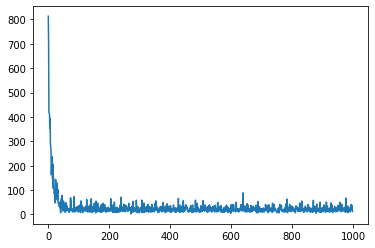

In [8]:
plt.plot(list(range(1000)), losses);

## 2.5 Assessing Our Model: Training Set Versus Testing Set
We use the training data to train the model (that is, to iteratively update the weights), and then we evaluate the model on the testing set to estimate its performance.

## 2.6 Assessing Our Model: The Code
With that understanding, let’s evaluate our model on the testing set. 

In [9]:
# Generate predictions from the step-by-step linear regression model.
def predict(X: ndarray, weights: Dict[str, ndarray]):
    N = np.dot(X, weights['W'])
    return N + weights['B']

Then we simply use the weights returned earlier from the train function and write:

In [10]:
preds = predict(X_test, weights)

How good are these predictions? Keep in mind that at this point we haven’t validated our seemingly strange approach of defining models as a series of operations, and training them by iteratively adjusting the parameters involved using the partial derivatives of the loss calculated with respect to the parameters using the chain rule; thus, we should be pleased if this approach works at all.

The first thing we can do to see whether our model worked is to make a plot with the model’s predictions on the $x$-axis and the actual values on the $y$-axis. If every point fell exactly on the $45$-degree line, the model would be perfect. `Figure 2-6` shows a plot of our model’s predicted and actual values.

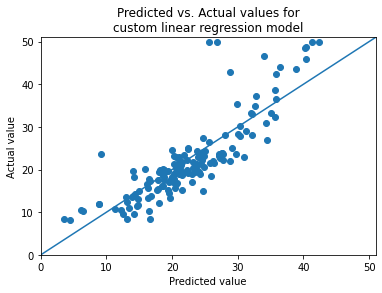

In [11]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

In [12]:
"Mean absolute error: {mae}".format(mae=round(mae(preds, y_test), 4))

'Mean absolute error: 3.5644'

In [13]:
"Root mean squared error: {rmse}".format(rmse=round(rmse(preds, y_test), 4))

'Root mean squared error: 5.0497'

Root mean squared error is a particularly common metric since it is on the same scale as the target. If we divide this number by the mean value of the target, we can get a measure of how far off a prediction is, on average, from its actual value. Since the mean value of `y_test` is $22.0776$, we see that this model’s predictions of house prices are off by $\displaystyle\frac{5.0508}{22.0776} ≅ 22.9\%$ on average.

### Analyzing the Most Important Feature
Before beginning modeling, we scaled each feature of our data to have mean $0$ and standard deviation $1$; this has computational advantages that we’ll discuss in more detail in `Chapter 4`. A benefit of doing this that is specific to linear regression is that we can interpret the absolute values of the coefficients as corresponding to the importance of the different features to the model; a larger coefficient means that the feature is more important. Here are the coefficients:

In [14]:
np.round(weights['W'].reshape(-1), 4)

array([-1.0954,  0.7353,  0.1977,  0.7475, -2.2849,  2.2006,  0.7195,
       -2.6384,  2.5358, -1.6892, -2.3162,  0.8435, -4.2553])

The fact that the last coefficient is largest means that the last feature in the dataset is the most important one.

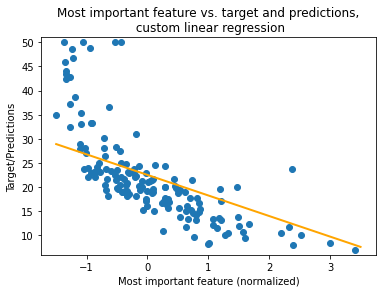

In [15]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n custom linear regression");

We see that this feature is indeed strongly correlated with the target: as this feature increases, the value of the target decreases, and vice versa. However, this relationship is not linear. The expected amount that the target changes as the feature changes from $–2$ to $–1$ is not the same amount that it changes as the feature changes from $1$ to $2$. We’ll come back to this later.

This figure shows (literally) a limitation of linear regression: despite the fact that there is a visually clear and “model-able” nonlinear relationship between this feature and the target, our model is only able to “learn” a linear relationship because of its intrinsic structure.

To have our model learn a more complex, nonlinear relationship between our features and our target, we’re going to have to build a more complicated model than linear regression. 